<a href="https://colab.research.google.com/github/gullsherk/Dataset/blob/master/Credit_Prediction_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre Processing


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn import preprocessing
import plotly.offline as py 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import model_selection
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
from collections import Counter # To do counter of some features

def plot_bar_x(title,xlabel,ylabel,label,data):
    index = np.arange(len(label))
    plt.bar(index, data)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(index, label, fontsize=15, rotation=90)
    plt.title(title)
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

Using TensorFlow backend.


In [2]:
#importing dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
dataset = pd.read_csv('/content/gdrive/My Drive/dataset_CreditPrediction.csv')

In [4]:
#Viewing dataset columns
dataset.head()

,credit,summe_einnahmen,summe_ausgaben,frei_verfuegbares_einkommen,verhaeltnis_einkommen_zu_rate,laufzeit,kreditbetrag,score_wert,schufa_score,anzahl_kinder,anzahl_personen,anzahl_kfz,beschaeftigungs_art,anrede,familienstand,wohnsituation,einkommen_unselbstaendig,rente,ein_unterhalt,kindergeld,ein_miete,sonstiges,aus_miete,wohnnebenkosten,aus_unterhalt,kranken_pflege_versicherung,lebensversicherung,baufinanzierung,bausparen,beschaeftigt_seit,alter,wohnhaft
0,ABGELEHNT,1069.0,1623.263889,-554.0,0.65,60,4990.0,268,9657,1,3,0,ANGESTELLTER,HERR,VERHEIRATET,MIETE,1068.0,0.0,0.0,1.0,0.0,NaN,570.0,NaN,0.0,NaN,0.0,0.0,0.0,2006-07-01 00:00:00,49.0,6.0
1,ABGELEHNT,2988.0,3192.191043,-204.0,0.70,24,5000.0,175,9712,2,3,1,BEAMTER,HERR,LEDIG,MIETE,2600.0,NaN,NaN,388.0,NaN,NaN,720.0,NaN,NaN,280.0,NaN,NaN,NaN,2010-10-01 00:00:00,41.0,7.0
2,ABGELEHNT,2088.0,1900.000000,188.0,0.60,72,7000.0,26,9830,2,4,0,ANGESTELLTER,FRAU,VERHEIRATET,MIETE,1700.0,0.0,0.0,2.0,0.0,NaN,650.0,NaN,0.0,NaN,0.0,0.0,0.0,2005-01-01 00:00:00,33.0,11.0
3,ABGELEHNT,2055.0,1873.750000,181.0,0.60,72,7000.0,254,9946,0,1,1,ANGESTELLTER,HERR,GESCHIEDEN,MIETE,2055.0,0.0,0.0,0.0,0.0,NaN,478.0,NaN,0.0,NaN,197.0,0.0,0.0,2006-02-01 00:00:00,50.0,6.0
4,ABGELEHNT,1688.0,1337.592723,350.0,0.60,84,10000.0,286,9673,2,4,0,ANGESTELLTER,HERR,VERHEIRATET,EIGENTUM,1300.0,0.0,0.0,384.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,300.0,0.0,2002-01-01 00:00:00,38.0,11.0


In [5]:
#Visualizing the data -- Bar Plot of Classification groups
trace0 = go.Bar(
            x = dataset[dataset["credit"]== 'GENEHMIGT']["credit"].value_counts().index.values,
            y = dataset[dataset["credit"]== 'GENEHMIGT']["credit"].value_counts().values,
            name='Good credit')

trace1 = go.Bar(
            x = dataset[dataset["credit"]== 'ABGELEHNT']["credit"].value_counts().index.values,
            y = dataset[dataset["credit"]== 'ABGELEHNT']["credit"].value_counts().values,
            name='Bad credit')

Risk_Variable_Distribution_Data = [trace0, trace1]

layout = go.Layout(
    
)

Risk_Variable_Distribution_Layout = go.Layout(
    yaxis=dict(title='Count'),
    xaxis=dict(title='Risk Variable'),
    title='Target variable distribution'
)

fig = go.Figure(data=Risk_Variable_Distribution_Data, layout=Risk_Variable_Distribution_Layout)

py.iplot(fig, filename='TargetVariableDistribution-bar')

In [6]:
trace0 = go.Bar(
    x = dataset[dataset["credit"]== 'GENEHMIGT']["beschaeftigungs_art"].value_counts().index.values,
    y = dataset[dataset["credit"]== 'GENEHMIGT']["beschaeftigungs_art"].value_counts().values,
    name='Good credit Distribuition'
)

trace1 = go.Bar(
    x = dataset[dataset["credit"]== 'ABGELEHNT']["beschaeftigungs_art"].value_counts().index.values,
    y = dataset[dataset["credit"]== 'ABGELEHNT']["beschaeftigungs_art"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='JobDistribution-bar')

In [0]:
dataset.replace({"\\N" : None}, inplace = True)

In [0]:
#Converting Categorical Data to Numerical
lb_make = LabelEncoder()
dataset["credit"] = lb_make.fit_transform(dataset["credit"])
dataset["beschaeftigungs_art"] = lb_make.fit_transform(dataset["beschaeftigungs_art"]).astype('float64')
dataset["anrede"] = lb_make.fit_transform(dataset["anrede"]).astype('float64')
dataset["familienstand"] = lb_make.fit_transform(dataset["familienstand"]).astype('float64')


for index, row in dataset.head().iterrows():
  if (row['wohnsituation'] in ['EINGENTUM','ELTERN']):
    row['aus_miete']=0


dataset["wohnsituation"] = lb_make.fit_transform(dataset["wohnsituation"]).astype('float64')


#Converting data to float types
dataset["laufzeit"] = dataset["laufzeit"].astype('float64')
dataset["score_wert"] = dataset["score_wert"].astype('float64')
dataset["schufa_score"] = dataset["schufa_score"].astype('float64')
dataset["anzahl_kinder"] = dataset["anzahl_kinder"].astype('float64')
dataset["anzahl_personen"] = dataset["anzahl_personen"].astype('float64')
dataset["anzahl_kfz"] = dataset["anzahl_kfz"].astype('float64')

#Caculating time employed since

from datetime import datetime
dataset['beschaeftigt_seit'] = ( pd.to_datetime(dataset['beschaeftigt_seit'], format="%Y-%m-%d"))
dataset['beschaeftigt_seit'] = (((2019 - dataset['beschaeftigt_seit'].dt.year)*12) + (10-dataset['beschaeftigt_seit'].dt.month)).astype('float64')



In [9]:
dataset.head()

,credit,summe_einnahmen,summe_ausgaben,frei_verfuegbares_einkommen,verhaeltnis_einkommen_zu_rate,laufzeit,kreditbetrag,score_wert,schufa_score,anzahl_kinder,anzahl_personen,anzahl_kfz,beschaeftigungs_art,anrede,familienstand,wohnsituation,einkommen_unselbstaendig,rente,ein_unterhalt,kindergeld,ein_miete,sonstiges,aus_miete,wohnnebenkosten,aus_unterhalt,kranken_pflege_versicherung,lebensversicherung,baufinanzierung,bausparen,beschaeftigt_seit,alter,wohnhaft
0,0,1069.0,1623.263889,-554.0,0.65,60.0,4990.0,268.0,9657.0,1.0,3.0,0.0,0.0,1.0,5.0,2.0,1068.0,0.0,0.0,1.0,0.0,NaN,570.0,NaN,0.0,NaN,0.0,0.0,0.0,159.0,49.0,6.0
1,0,2988.0,3192.191043,-204.0,0.70,24.0,5000.0,175.0,9712.0,2.0,3.0,1.0,2.0,1.0,4.0,2.0,2600.0,NaN,NaN,388.0,NaN,NaN,720.0,NaN,NaN,280.0,NaN,NaN,NaN,108.0,41.0,7.0
2,0,2088.0,1900.000000,188.0,0.60,72.0,7000.0,26.0,9830.0,2.0,4.0,0.0,0.0,0.0,5.0,2.0,1700.0,0.0,0.0,2.0,0.0,NaN,650.0,NaN,0.0,NaN,0.0,0.0,0.0,177.0,33.0,11.0
3,0,2055.0,1873.750000,181.0,0.60,72.0,7000.0,254.0,9946.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,2055.0,0.0,0.0,0.0,0.0,NaN,478.0,NaN,0.0,NaN,197.0,0.0,0.0,164.0,50.0,6.0
4,0,1688.0,1337.592723,350.0,0.60,84.0,10000.0,286.0,9673.0,2.0,4.0,0.0,0.0,1.0,5.0,0.0,1300.0,0.0,0.0,384.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,300.0,0.0,213.0,38.0,11.0


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16965 entries, 0 to 16964
Data columns (total 32 columns):
credit                           16965 non-null int64
summe_einnahmen                  16965 non-null float64
summe_ausgaben                   16965 non-null float64
frei_verfuegbares_einkommen      16965 non-null float64
verhaeltnis_einkommen_zu_rate    16965 non-null float64
laufzeit                         16965 non-null float64
kreditbetrag                     16965 non-null float64
score_wert                       16965 non-null float64
schufa_score                     16965 non-null float64
anzahl_kinder                    16965 non-null float64
anzahl_personen                  16965 non-null float64
anzahl_kfz                       16965 non-null float64
beschaeftigungs_art              16965 non-null float64
anrede                           16965 non-null float64
familienstand                    16965 non-null float64
wohnsituation                    16965 non-null float

In [11]:
print("---------------------------------------------------- Null values in the Dataset")
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()*100).sort_values(ascending=False)
pd.concat([total, percent], axis = 1, keys=['Total Values', 'Percent'])

---------------------------------------------------- Null values in the Dataset


,Total Values,Percent
sonstiges,4181,24.644857
wohnnebenkosten,3024,17.824934
kranken_pflege_versicherung,2921,17.217801
bausparen,1513,8.918361
aus_miete,1476,8.700265
lebensversicherung,1359,8.010610
rente,1180,6.955497
ein_unterhalt,1168,6.884763
ein_miete,1095,6.454465
aus_unterhalt,1039,6.124374


In [12]:
dataset.head()

,credit,summe_einnahmen,summe_ausgaben,frei_verfuegbares_einkommen,verhaeltnis_einkommen_zu_rate,laufzeit,kreditbetrag,score_wert,schufa_score,anzahl_kinder,anzahl_personen,anzahl_kfz,beschaeftigungs_art,anrede,familienstand,wohnsituation,einkommen_unselbstaendig,rente,ein_unterhalt,kindergeld,ein_miete,sonstiges,aus_miete,wohnnebenkosten,aus_unterhalt,kranken_pflege_versicherung,lebensversicherung,baufinanzierung,bausparen,beschaeftigt_seit,alter,wohnhaft
0,0,1069.0,1623.263889,-554.0,0.65,60.0,4990.0,268.0,9657.0,1.0,3.0,0.0,0.0,1.0,5.0,2.0,1068.0,0.0,0.0,1.0,0.0,NaN,570.0,NaN,0.0,NaN,0.0,0.0,0.0,159.0,49.0,6.0
1,0,2988.0,3192.191043,-204.0,0.70,24.0,5000.0,175.0,9712.0,2.0,3.0,1.0,2.0,1.0,4.0,2.0,2600.0,NaN,NaN,388.0,NaN,NaN,720.0,NaN,NaN,280.0,NaN,NaN,NaN,108.0,41.0,7.0
2,0,2088.0,1900.000000,188.0,0.60,72.0,7000.0,26.0,9830.0,2.0,4.0,0.0,0.0,0.0,5.0,2.0,1700.0,0.0,0.0,2.0,0.0,NaN,650.0,NaN,0.0,NaN,0.0,0.0,0.0,177.0,33.0,11.0
3,0,2055.0,1873.750000,181.0,0.60,72.0,7000.0,254.0,9946.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,2055.0,0.0,0.0,0.0,0.0,NaN,478.0,NaN,0.0,NaN,197.0,0.0,0.0,164.0,50.0,6.0
4,0,1688.0,1337.592723,350.0,0.60,84.0,10000.0,286.0,9673.0,2.0,4.0,0.0,0.0,1.0,5.0,0.0,1300.0,0.0,0.0,384.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,300.0,0.0,213.0,38.0,11.0


In [0]:
dataset.to_csv('PreProcessedData.csv', index=False)

In [0]:
#imputing NA
#dataset.fillna(dataset.median(), inplace=True)


In [0]:
#dividing label and Data
y = dataset['credit']
X = dataset.drop('credit',axis=1)

In [15]:


# Use 3 nearest rows which have a feature to fill in each row's missing features
X = KNN(k=3).fit_transform(X)


Imputing row 1/16965 with 3 missing, elapsed time: 79.399
Imputing row 101/16965 with 0 missing, elapsed time: 79.416
Imputing row 201/16965 with 6 missing, elapsed time: 79.427
Imputing row 301/16965 with 0 missing, elapsed time: 79.443
Imputing row 401/16965 with 0 missing, elapsed time: 79.463
Imputing row 501/16965 with 1 missing, elapsed time: 79.478
Imputing row 601/16965 with 0 missing, elapsed time: 79.495
Imputing row 701/16965 with 0 missing, elapsed time: 79.512
Imputing row 801/16965 with 0 missing, elapsed time: 79.537
Imputing row 901/16965 with 0 missing, elapsed time: 79.564
Imputing row 1001/16965 with 0 missing, elapsed time: 79.585
Imputing row 1101/16965 with 3 missing, elapsed time: 79.620
Imputing row 1201/16965 with 0 missing, elapsed time: 79.648
Imputing row 1301/16965 with 0 missing, elapsed time: 79.673
Imputing row 1401/16965 with 0 missing, elapsed time: 79.716
Imputing row 1501/16965 with 3 missing, elapsed time: 79.736
Imputing row 1601/16965 with 9 missi

In [0]:
#Shuffle Data
from sklearn.utils import shuffle

X, y = shuffle(X, y)

In [0]:
#Dividing the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# XG Boost Classifier


In [0]:
#convert the dataset into an optimized data structure called Dmatrix that XGBoost supports
data_dmatrix = xgb.DMatrix(data=X,label=y)
 


In [0]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

In [20]:
xg_reg.fit(X_train,y_train)


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
predsTrain = xg_reg.predict(X_train)
predsTest = xg_reg.predict(X_test)



In [22]:
rmse = np.sqrt(mean_squared_error(y_train, predsTrain))
print("RMSE: %f" % (rmse))

RMSE: 0.558319


In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, predsTrain)


0.6882801664355063

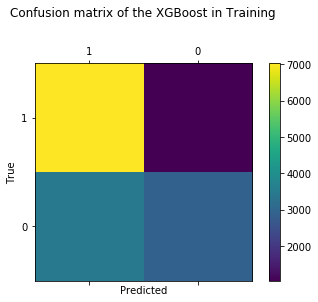

In [24]:
labels = [1, 0]
cm = confusion_matrix(y_train, predsTrain, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the XGBoost in Training\n\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
importances = xg_reg.feature_importances_
#Sort it
print ("Feature Importance:")
sorted_feature_importance = sorted(zip(importances, dataset.columns), reverse=True)
for i in sorted_feature_importance:
    print(i)

Feature Importance:
(0.17118576, 'frei_verfuegbares_einkommen')
(0.14136077, 'score_wert')
(0.062137682, 'laufzeit')
(0.05742045, 'ein_miete')
(0.05571139, 'summe_ausgaben')
(0.053665724, 'kranken_pflege_versicherung')
(0.04777346, 'wohnsituation')
(0.039441418, 'anzahl_personen')
(0.034986917, 'aus_unterhalt')
(0.03466048, 'ein_unterhalt')
(0.02808135, 'credit')
(0.025560334, 'aus_miete')
(0.025553795, 'sonstiges')
(0.023752136, 'familienstand')
(0.023254309, 'bausparen')
(0.01797649, 'schufa_score')
(0.017845932, 'verhaeltnis_einkommen_zu_rate')
(0.017764, 'wohnnebenkosten')
(0.01753708, 'anrede')
(0.01571152, 'beschaeftigungs_art')
(0.014330566, 'kreditbetrag')
(0.0124157, 'rente')
(0.012314548, 'anzahl_kinder')
(0.0121980505, 'summe_einnahmen')
(0.011707733, 'kindergeld')
(0.011447078, 'beschaeftigt_seit')
(0.00827989, 'lebensversicherung')
(0.0059254244, 'baufinanzierung')
(0.0, 'einkommen_unselbstaendig')
(0.0, 'anzahl_kfz')
(0.0, 'alter')


In [26]:
#implementing grid search for best results of XG Boost
optimization_dict = {'max_depth': [4,6,8],
                     'n_estimators': [100,200,400]}

model_Grid_XGBoost = GridSearchCV(xg_reg, optimization_dict, 
                     scoring='accuracy', verbose=1,cv=5 )

model_Grid_XGBoost.fit(X_train,y_train)
print(model_Grid_XGBoost.best_score_)
print(model_Grid_XGBoost.best_params_)
preds = model_Grid_XGBoost.best_estimator_.predict(X_test)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.0min finished


0.7088072122052704
{'max_depth': 4, 'n_estimators': 400}


In [0]:
XGBoostTrainAccuracy = model_Grid_XGBoost.best_score_


In [28]:
print("Train Accuracy :",XGBoostTrainAccuracy)
XGBoostTestAccuracy = accuracy_score(y_test, preds)
print("Test Accuracy :",accuracy_score(y_test, preds))

Train Accuracy : 0.7088072122052704
Test Accuracy : 0.7056974459724951


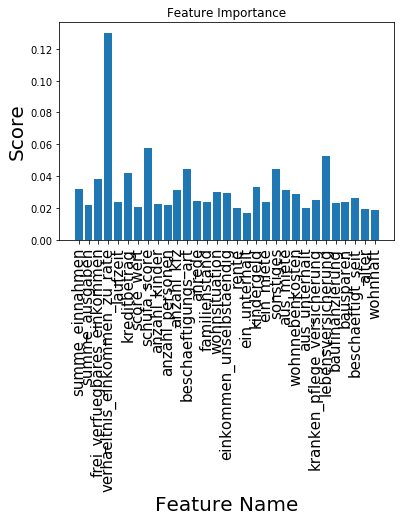

In [29]:
importances = model_Grid_XGBoost.best_estimator_.feature_importances_

# feature importance
FeatureNames = list(dataset.columns.values)
FeatureNames = FeatureNames[1:]

# plot

plot_bar_x("Feature Importance","Feature Name","Score",FeatureNames,importances)


plt.show()

Confusion matrix, without normalization
[[ 677  465]
 [ 284 1119]]


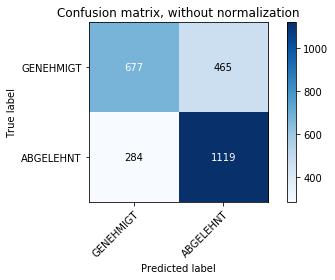

In [30]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['GENEHMIGT','ABGELEHNT'], yticklabels=['GENEHMIGT','ABGELEHNT'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = dataset.columns #['ABGELEHNT','GENEHMIGT']

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, preds, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

--------------------------------------------------- ROC Curve for XGBoost Classifier
AUC Test (Yellow line): 0.695
AUC Train (Green line): 0.664


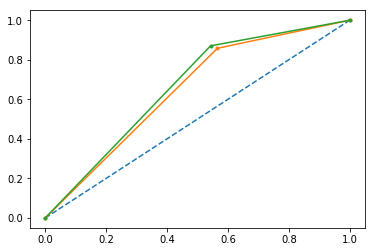

In [31]:
print("--------------------------------------------------- ROC Curve for XGBoost Classifier")
auc = roc_auc_score(y_test, preds)
auc2 = roc_auc_score(y_train, predsTrain)
print('AUC Test (Yellow line): %.3f' % auc)
print('AUC Train (Green line): %.3f' % auc2)

# calculate roc curve

fpr, tpr, thresholds = roc_curve(y_test, predsTest)
fpr2, tpr2, thresholds2 = roc_curve(y_train, predsTrain)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# plot the roc curve for the model
plt.plot(fpr2, tpr2, marker='.')
# show the plot
plt.show()

In [32]:

kfold = model_selection.KFold(n_splits=5, random_state=7)
results = model_selection.cross_val_score(model_Grid_XGBoost, X, y, cv=kfold)
print("Accuracy: Final mean: %.3f%% , Final standard deviation: (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
print('Accuracies from each of the 5 folds using kfold:',results)
print("Variance of kfold accuracies:",results.var())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.9min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.8min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.9min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.9min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.9min finished


Accuracy: Final mean: 70.928% , Final standard deviation: (0.720%)
Accuracies from each of the 5 folds using kfold: [0.71 0.7  0.72 0.71 0.7 ]
Variance of kfold accuracies: 5.1895126744969944e-05


# Random Forest Classifier

In [33]:
#This Tunning Model May give better accuracy but it will take 5-7 hours to run on colab and 10-15 on average local machine
#param_grid = {'bootstrap': [True, False],
# 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
# 'max_features': np.arange(5,8),
# 'min_samples_leaf': [10,50,100,200,500],
# 'min_samples_split': [2, 5, 10],
# 'n_estimators': [600]
  #           }

SyntaxError: ignored

In [0]:
param_grid = {
 'bootstrap': [True, False],
 'max_depth': [10, 50, 100, None],
 'max_features': np.arange(5,8),
 'min_samples_leaf': [10,50,100],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [500]
             }

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier()
np.random.seed(42)

In [0]:
grid_searcher= GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, verbose=2)

In [0]:
grid_searcher.fit(X_train, y_train)


In [0]:
np.set_printoptions(precision=2)

class_names = dataset.columns 

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predictionRandomForestTest, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [0]:
labels = [1, 0]
cm = confusion_matrix(y_test, predictionRandomForestTest, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the Random Forest\n\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [0]:
importances = grid_searcher.best_estimator_.feature_importances_

print ("Sorted Feature Importance:")
sorted_feature_importance = sorted(zip(importances, dataset.columns), reverse=True)
for i in sorted_feature_importance:
    print(i)

In [0]:
# feature importance
FeatureNames = list(dataset.columns.values)
FeatureNames = FeatureNames[1:]

# plot

plot_bar_x("Feature Importance","Feature Name","Score",FeatureNames,importances)


plt.show()

In [0]:
predictionRandomForestTest = grid_searcher.best_estimator_.predict(X_test)
predictionRandomForestTrain =grid_searcher.best_estimator_.predict(X_train)
RandomForestTrainAccuracy = accuracy_score(y_train, predictionRandomForestTrain)
RandomForestTestAccuracy = accuracy_score(y_test, predictionRandomForestTest)


In [0]:
print("--------------------------------------------------- ROC Curve for Random Forest Classifier")
auc = roc_auc_score(y_test, predictionRandomForestTest)
auc2 = roc_auc_score(y_train, predictionRandomForestTrain)
print('AUC Test (Yellow line): %.3f' % auc)
print('AUC Train (Green line): %.3f' % auc2)

# calculate roc curve

fpr, tpr, thresholds = roc_curve(y_test, predictionRandomForestTest)
fpr2, tpr2, thresholds2 = roc_curve(y_train, predictionRandomForestTrain)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# plot the roc curve for the model
plt.plot(fpr2, tpr2, marker='.')
# show the plot
plt.show()

# NEURAL NETWORK CLASSIFIER


In [0]:
from keras import regularizers,optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import tensorflow
from keras.layers import Input, Activation, MaxPooling2D


In [0]:

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_valid=sc.transform(X_valid)

In [0]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.1, verbose=1),
    ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)
]

In [0]:
from keras.regularizers import l2

model = Sequential([
    Dense(units=32, input_dim = 31,activation='relu'),
    Dense(units=64,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'),
    Dense(units=32,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'),
    Dense(units=14,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu'),
    Dense(1,activation='sigmoid'),
])

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [0]:
train_model = model.fit(X_train, y_train,batch_size=3, epochs=150,
                        validation_data=(X_valid, y_valid),
                        callbacks = callbacks)

In [0]:
model = load_model('best_model.h5')

In [0]:
prediction_train = model.predict(X_train)
prediction_train = prediction_train.flatten()
prediction_train[prediction_train > 0.5] = 1
prediction_train[prediction_train <= 0.5] = 0

prediction_test=model.predict(X_valid)
prediction_test = prediction_test.flatten()
prediction_test[prediction_test > 0.5] = 1
prediction_test[prediction_test <= 0.5] = 0

NeuralNetworkTestAccuracy =   accuracy_score(y_valid,prediction_test)
NeuralNetworkTrainAccuracy= accuracy_score(y_train,prediction_train)

print("Train: ",NeuralNetworkTrainAccuracy)

print("Test: ",NeuralNetworkTestAccuracy)
neuralNetworkPrediction=model.predict(X_valid)

np.set_printoptions(precision=2)

class_names = dataset.columns 

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_valid, prediction_test, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [0]:
print("--------------------------------------------------- ROC Curve for Neural Network Classifier")
auc = roc_auc_score(y_valid, prediction_test)
auc2 = roc_auc_score(y_train, prediction_train)
print('AUC Test (Yellow line): %.3f' % auc)
print('AUC Train (Green line): %.3f' % auc2)

# calculate roc curve

fpr, tpr, thresholds = roc_curve(y_valid, prediction_test)
fpr2, tpr2, thresholds2 = roc_curve(y_train, prediction_train)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# plot the roc curve for the model
plt.plot(fpr2, tpr2, marker='.')
# show the plot
plt.show()

In [0]:
plt.plot(train_model.history['acc'])
plt.plot(train_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Accuracy Bar Plot for Different Classifiers

In [0]:
import matplotlib.pyplot as plt
import numpy as np
label = ['XGBoost', 'Random Forest', 'Neural Network']
data = [XGBoostTestAccuracy,RandomForestTestAccuracy,NeuralNetworkTestAccuracy]


In [0]:
plot_bar_x("Accuracy Plot for the classifiers ","Classifier Name","Accuracy",label,data)